# Convolutional Neural Networks

## Project: Dog Breed Classifier

---

### Domain background

Image recognition and classification has always been an important investigation field for computer vision. It has gained a lot of popularity and advances since the introduction of Deep Learning.
Most investigations are focusing on using Convolutional Neural Networks (CNN)s to the fact that they are capable of recognizing and classifying a wide variety of objects and images. A lot of research has gone in to the training of CNNs on a variety of datasets, most focusing on the optimization of a particular network’s performance. 

### Problem Statement

There are many different dog breeds around the world, and some of them with similar physical characteristics. Being able to recognize each dog breed is a challenging task even for humans, therefore the necessity of using machine learning for performing this task. A convolutional neural network (CNN) will be used to accomplish this challenge.
The aim of this project is to build a pipeline to process real-world, user-supplied images. Given an image of a dog, the algorithm will identify an estimate of the canine’s breed. If supplied an image of a human, the code will identify the resembling dog breed. If neither a dog nor a human is detected, then an error message is output. 

Some sample output of the algorithm is provided below:

![Sample Dog Output](images/sample_dog_output.png)

![Sample Human Output](images/sample_human_output.png)


### Project Workflow

The project workflow to approach the solution is the following: 

* [Step 0](#step0): Define Imports
* [Step 1](#step1): Import Datasets
* [Step 2](#step2): Data Exploration - Human dataset
* [Step 3](#step3): Data Exploration - Dog breeds dataset
* [Step 4](#step4): Create Utilities Functions
* [Step 5](#step5): Create Benchmark Model
* [Step 6](#step6): Create Proposed Model
* [Step 7](#step7): Model Refinement
* [Step 8](#step8): Model Evaluation and Validation

<a id='step0'></a>
## Step 0: Define Imports

All necessary imports for the projects are defined.

In [1]:
# Define all the imports
import cv2  
import numpy as np
import sys
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

from glob import glob
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from PIL import Image
from PIL import ImageFile
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

ImageFile.LOAD_TRUNCATED_IMAGES = True

<a id='step1'></a>
## Step 1: Import Datasets

The datasets for the human and dog images are imported.

In [2]:
# Load human images dataset
human_files = np.array(glob("/data/lfw/*/*"))

# Load dog breeds images dataset
dog_files = np.array(glob("/data/dog_images/*/*/*"))

<a id='step2'></a>
## Step 2: Data Exploration - Human dataset

Use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  Next code downloads one of these detectors and stores it in the `haarcascades` directory.

In [3]:
# Print number of images in human dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


Number of faces detected: 1


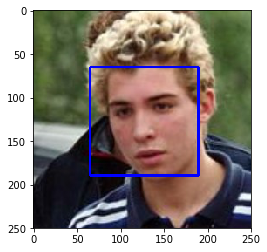

In [4]:
# Extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[2])

# Convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find faces in image
faces = face_cascade.detectMultiScale(gray)

# Print number of faces detected in the image
print('Number of faces detected:', len(faces))

# Get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# Convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

Create a function that returns `True` if a human face is detected in an image and `False` otherwise.

In [3]:
def human_face_detector(image_path):
    ''' Verify if a human face was detected in a given image path
    '''
    
    # load color (BGR) image
    color_image = cv2.imread(image_path)
    
    # Convert BGR image to grayscale
    gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
    
    # Find faces in image
    faces = face_cascade.detectMultiScale(gray_image)
    
    # Obtain number of detected human faces
    number_detected_faces = len(faces)
    
    # Check if there are human faces detected
    detected_face = number_detected_faces > 0
    
    return detected_face

In [4]:
def verify_detector_performance(func, expected_human_faces, expected_dog_breeds):
    ''' Verify the performance of a given detector.
        It determines the number of detected human and 
        dog breed images.
    '''
    # Use only 100 images for the verification
    number_images = 100
    
    # Obtain human and dog images for verification
    human_files_short = human_files[:number_images]
    dog_files_short = dog_files[:number_images]

    # Count the number of detected human faces
    detected_human_faces = 0

    # Count the number of detected dog breeds
    detected_dog_breeds = 0

    # Iterates throw each human image to detect a face
    for human_image in human_files_short:
        detected_human_faces += func(human_image)

    # Iterates throw each dog image to detect
    for dog_image in dog_files_short:
        detected_dog_breeds += func(dog_image)

    print("Percentage of detected human faces is: {}%. Expected: {}%".format(detected_human_faces, expected_human_faces))
    print("Percentage of detected dog breeds is: {}%. Expected: {}%".format(detected_dog_breeds, expected_dog_breeds))

In [7]:
# Check the performance of the human face detector
verify_detector_performance(func = human_face_detector,
                            expected_human_faces = 100, 
                            expected_dog_breeds = 0)

Percentage of detected human faces is: 98%. Expected: 100%
Percentage of detected dog breeds is: 17%. Expected: 0%


<a id='step3'></a>
## Step 3: Data Exploration - Dog breeds dataset

In [8]:
# Print number of images in dog breeds dataset
print('There are %d total dog images.' % len(dog_files))

There are 8351 total dog images.


In [9]:
# Contains the types of data
types_data = ['train', 'valid', 'test']

# Check the number of images per data type
for type_data in types_data:
    images = np.array(glob("/data/dog_images/{}/*/*".format(type_data)))

    print("There are {} total {} dog images.".format(len(images), type_data))

There are 6680 total train dog images.
There are 835 total valid dog images.
There are 836 total test dog images.


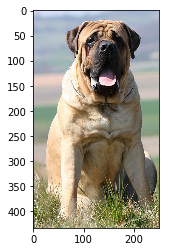

In [10]:
# load color (BGR) image
bgr_image = cv2.imread(dog_files[2])

# Convert BGR image to RGB for plotting
rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

# Display the image, along with bounding box
plt.imshow(rgb_image)
plt.show()

<a id='step4'></a>
## Step 4: Create Utilities Functions

Create utilities functions and global variables that are going to be necessary in the entire project.

In [5]:
# Mean and standard deviation of the images color channels
mean_values = [0.485, 0.456, 0.406]
std_values = [0.229, 0.224, 0.225]

# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dogs images directory path
data_directory = '/data/dog_images'

# Total classes of dog breeds
number_of_dog_classes = 133 

In [6]:
def create_transforms():
    ''' Create transforms for the training, validation, and testing sets
    '''

    # Tranform for the training data using image augmentation
    train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                           transforms.RandomResizedCrop(224),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean_values, std_values)])

    # Tranform for the validation data
    valid_transforms = transforms.Compose([transforms.Resize(255),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean_values, std_values)])

    # Tranform for the testing data
    test_transforms = transforms.Compose([transforms.Resize(255),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean_values, std_values)])
    
    result_transforms = {"train": train_transforms,
                         "valid": valid_transforms,
                         "test":  test_transforms
                        }
    
    return result_transforms